In [223]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [224]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
memory_TDP = 9.4 # watt
GPU_utilisation =  45 #percentage
CPU_utilisation = 1 #assumed

## nvidia-smi readings

In [225]:
def read_data(url):
    df_cpu = pd.read_csv(url)
    df = df_cpu.loc[df_cpu[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df, df_cpu

In [226]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [227]:
def power_reading(url):
    df, df_cpu = read_data(url)
    time_interval = time_duration(df)
    cpu_time_interval = time_duration(df_cpu)
    
    mean_power = df[' power.draw [W]'].mean()

    summed_power = df[' power.draw [W]'].sum() / (1000 *60*60)
    cpu_energy = (85 * cpu_time_interval) / (1000 *60*60)
    
    gpu_util = df[' utilization.gpu [%]'].mean()
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    end_time = df_cpu.iloc[-1].timestamp
    start_time = df_cpu.iloc[0].timestamp
   
    data = []
 
    data = [extract[2], 
            mean_power,time_interval,summed_power,gpu_util,
            memory_util,memory_used,
            cpu_time_interval]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
    return df, data

In [228]:
import os
folder_name = 'nvidia_inference'
result = pd.DataFrame(columns=['model',
                               'mean_power','total_time','power','gpu_util',
                               'memory_util','memory_used',
                                'cpu_time'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    if(file_name not in ['.DS_Store']):
        url = folder_name + '/' + file_name
        df,data = power_reading(url)
       # print (data)
        if data:
            result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [229]:
# https://www.tensorflow.org/datasets/catalog/glue
train_dataset_sizes = {
    'MRPC': 3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI': 392702,
    'STS-B':8628,
    'STS-B':5749,
    'QQP':  363846,
    'RTE':  2490,
    'QNLI': 104743,
    'WNLI': 635
}
result['dataset_size'] = result['model']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [230]:
result_file = "results/inference_nvidia_energy.csv"
result.to_csv(result_file, index=False)

## power monitor readings

In [231]:
df_reading = pd.read_csv("results/new-inference.csv")

In [232]:
df_reading['last_changed'] = pd.to_datetime(df_reading['last_changed'], errors='coerce')
df_reading.dropna(subset=['last_changed'], inplace=True)
df_reading.set_index('last_changed', inplace=True)

In [233]:
df_time_interval = pd.read_csv("logs/inferenceTextClass1.csv")

In [234]:
df_time_interval['start_seconds']= [datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                  for start_time in df_time_interval.start_time]
df_time_interval['end_seconds'] = [datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                for end_time in df_time_interval.end_time]
df_time_interval['total_time'] = df_time_interval['end_seconds'] - df_time_interval['start_seconds']
df_time_interval['total_time'] = df_time_interval['total_time'].apply(lambda x: x.total_seconds())
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time
0,MRPC,2020-08-05 12:34:04.899817,2020-08-05 12:40:03.361838,2020-08-05 11:34:04.899817,2020-08-05 11:40:03.361838,358.462021
1,STS-B,2020-08-05 12:40:08.689517,2020-08-05 12:46:06.375373,2020-08-05 11:40:08.689517,2020-08-05 11:46:06.375373,357.685856
2,CoLA,2020-08-05 12:46:11.615604,2020-08-05 12:52:02.424696,2020-08-05 11:46:11.615604,2020-08-05 11:52:02.424696,350.809092


In [235]:
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start_seconds"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end_seconds"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start_seconds"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end_seconds"]]
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time
0,MRPC,2020-08-05 12:34:04.899817,2020-08-05 12:40:03.361838,2020-08-05 11:34:04.899817,2020-08-05 11:40:03.361838,358.462021,2020-08-05,2020-08-05,11:34:04,11:40:03
1,STS-B,2020-08-05 12:40:08.689517,2020-08-05 12:46:06.375373,2020-08-05 11:40:08.689517,2020-08-05 11:46:06.375373,357.685856,2020-08-05,2020-08-05,11:40:08,11:46:06
2,CoLA,2020-08-05 12:46:11.615604,2020-08-05 12:52:02.424696,2020-08-05 11:46:11.615604,2020-08-05 11:52:02.424696,350.809092,2020-08-05,2020-08-05,11:46:11,11:52:02


In [236]:
def power_mean(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return subset_df['power_consumption'].mean()

In [237]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [238]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'mean_power'] = power_mean(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [239]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'pm_energy_consumption'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [240]:
df_time_interval['power'] = df_time_interval['mean_power'] * df_time_interval['total_time']
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time,mean_power,pm_energy_consumption,power
0,MRPC,2020-08-05 12:34:04.899817,2020-08-05 12:40:03.361838,2020-08-05 11:34:04.899817,2020-08-05 11:40:03.361838,358.462021,2020-08-05,2020-08-05,11:34:04,11:40:03,234.545692,0.023455,84075.722652
1,STS-B,2020-08-05 12:40:08.689517,2020-08-05 12:46:06.375373,2020-08-05 11:40:08.689517,2020-08-05 11:46:06.375373,357.685856,2020-08-05,2020-08-05,11:40:08,11:46:06,237.677142,0.023768,85013.751869
2,CoLA,2020-08-05 12:46:11.615604,2020-08-05 12:52:02.424696,2020-08-05 11:46:11.615604,2020-08-05 11:52:02.424696,350.809092,2020-08-05,2020-08-05,11:46:11,11:52:02,225.129103,0.021950,78977.336053


In [241]:
result = result.merge(df_time_interval, on="model")
result

,model,mean_power_x,total_time_x,power_x,gpu_util,memory_util,memory_used,cpu_time,dataset_size,start_time,...,start_seconds,end_seconds,total_time_y,s_date,e_date,s_time,e_time,mean_power_y,pm_energy_consumption,power_y
0,STS-B,132.821239,356.279,0.013098,45.197183,15.118310,1553.0,357.289,5749,2020-08-05 12:40:08.689517,...,2020-08-05 11:40:08.689517,2020-08-05 11:46:06.375373,357.685856,2020-08-05,2020-08-05,11:40:08,11:46:06,237.677142,0.023768,85013.751869
1,CoLA,119.793066,350.220,0.011613,42.151862,14.911175,1553.0,350.222,8551,2020-08-05 12:46:11.615604,...,2020-08-05 11:46:11.615604,2020-08-05 11:52:02.424696,350.809092,2020-08-05,2020-08-05,11:46:11,11:52:02,225.129103,0.021950,78977.336053
2,MRPC,130.835983,357.292,0.012938,45.078652,15.073034,1553.0,358.335,3668,2020-08-05 12:34:04.899817,...,2020-08-05 11:34:04.899817,2020-08-05 11:40:03.361838,358.462021,2020-08-05,2020-08-05,11:34:04,11:40:03,234.545692,0.023455,84075.722652


In [242]:
df_co2 = pd.read_csv("results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

result['CO2e'] = uk_co2 * result['pm_energy_consumption']
result['kg CO2e'] = result['CO2e'] /1000

In [243]:
uk_co2

253.0

In [244]:
result['time * GPU TDP'] = result['total_time_x']/3600 * GPU_TDP  / 1000
result['time * (GPU + CPU + memory)'] =((result['total_time_x']/3600 * GPU_TDP) +
                                         (result['cpu_time']/3600 * (CPU_TDP + memory_TDP))) / 1000
result['time * (GPU + CPU + memory) * real_util'] = ((result['total_time_x']/3600 * 
                                                       GPU_TDP * result['gpu_util']/100 )
                                                  + (result['cpu_time']/3600 * 
                                                     (CPU_TDP * CPU_utilisation + memory_TDP))) / 1000

result['time * CPU'] = result['cpu_time']/3600 * CPU_TDP / 1000

In [245]:
features = ['model','time * GPU TDP','time * (GPU + CPU + memory)',
            'time * (GPU + CPU + memory) * real_util','pm_energy_consumption']
df = result[features]
df.rename(columns={'pm_energy_consumption':'empirical'},
                   inplace=True)
df.set_index('model', inplace=True)

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


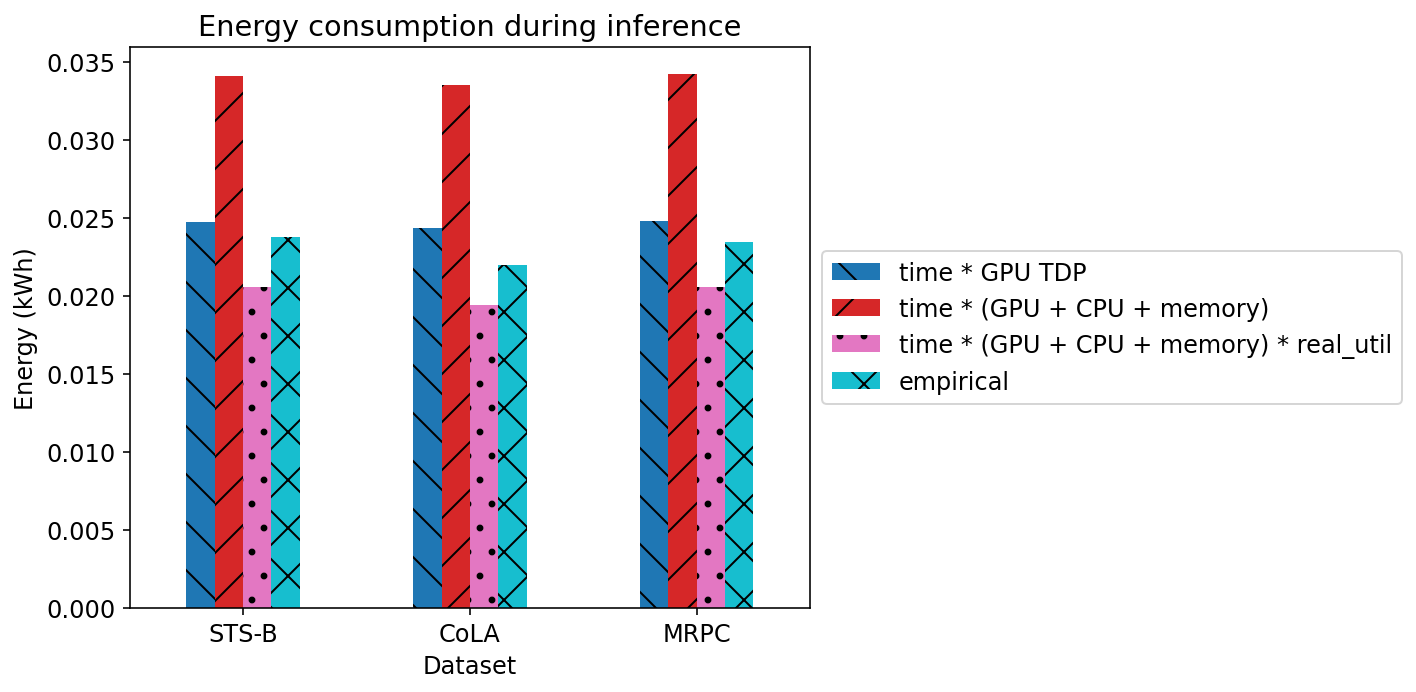

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
df.plot.bar(rot=0, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(df_plot) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel("Dataset")
ax.set_title("Energy consumption during inference")
plt.tight_layout()
ax.figure.savefig("viz/inferenceCompareEnergy.png",dpi=300)

In [253]:
df.to_csv("results/inferenceProcessedData.csv")

In [249]:
result.rename(columns={'pm_energy_consumption':'empirical'},
                   inplace=True)

In [250]:
features = ['model','time * GPU TDP','time * (GPU + CPU + memory)',
            'time * (GPU + CPU + memory) * real_util','empirical','kg CO2e']
bert_inference = result[features]
bert_inference.to_csv("results/bert_inference_appendix.csv", index=False)

## Data for overall energy consumed

In [197]:
df_time_interval['daily_consumption'] = 60 * 60 * 24 * 4000 * df_time_interval['pm_energy_consumption'] / df_time_interval['total_time']
df_time_interval['monthly_consumption'] = df_time_interval['daily_consumption'] * 30
df_time_interval['yearly_consumption'] = df_time_interval['daily_consumption'] * 365
df_time_interval

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time,mean_power,pm_energy_consumption,power,daily_consumption,monthly_consumption,yearly_consumption
0,MRPC,2020-08-05 12:34:04.899817,2020-08-05 12:40:03.361838,2020-08-05 11:34:04.899817,2020-08-05 11:40:03.361838,358.462021,2020-08-05,2020-08-05,11:34:04,11:40:03,234.545692,0.023455,84075.722652,22612.992811,678389.784339,8.253742e+06
1,STS-B,2020-08-05 12:40:08.689517,2020-08-05 12:46:06.375373,2020-08-05 11:40:08.689517,2020-08-05 11:46:06.375373,357.685856,2020-08-05,2020-08-05,11:40:08,11:46:06,237.677142,0.023768,85013.751869,22964.626300,688938.789014,8.382089e+06
2,CoLA,2020-08-05 12:46:11.615604,2020-08-05 12:52:02.424696,2020-08-05 11:46:11.615604,2020-08-05 11:52:02.424696,350.809092,2020-08-05,2020-08-05,11:46:11,11:52:02,225.129103,0.021950,78977.336053,21624.155169,648724.655061,7.892817e+06


In [198]:
df_time_interval['daily_consumption'].mean() *  5000000 * 0.01/100

11200295.713411884

In [199]:
df_time_interval['monthly_consumption'].mean() * 5000000 * 0.01/100

336008871.40235656

In [200]:
df_time_interval['yearly_consumption'].mean() * 5000000 * 0.01/100

4088107935.3953376

In [201]:
df_time_interval['daily_CO2e'] = uk_co2 * df_time_interval['daily_consumption']
df_time_interval['daily kg CO2e/kWh'] = df_time_interval['daily_CO2e'] /1000
df_time_interval['monthly_CO2e'] = uk_co2 * df_time_interval['monthly_consumption']
df_time_interval['monthly kg CO2e/kWh'] = df_time_interval['monthly_CO2e'] /1000
df_time_interval['yearly_CO2e'] = uk_co2 * df_time_interval['yearly_consumption']
df_time_interval['yearly kg CO2e/kWh'] = df_time_interval['yearly_CO2e'] /1000

In [202]:
## estimate from model
pretrain_consumption = 577
pretrain_with_hyperparameter = pretrain_consumption * 20
pretrain_daily = ((pretrain_with_hyperparameter / 96) / 20) * 24
pretrain_monthly = pretrain_daily * 30
pretrain_monthly_co2 = uk_co2 * pretrain_monthly / 1000
pretrain_daily_co2 = uk_co2 * pretrain_daily / 1000
pretrain_yearly = pretrain_with_hyperparameter
pretrain_yearly_co2 = uk_co2 * pretrain_with_hyperparameter / 1000
pretrain_array = ["Pre-training",pretrain_daily, pretrain_monthly, pretrain_yearly,pretrain_daily_co2,
                  pretrain_monthly_co2,pretrain_yearly_co2]


In [203]:
## better way 
inference_array = ["Inference",
                   df_time_interval['daily_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['monthly_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['yearly_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['daily kg CO2e/kWh'].mean() *  5000000 * 0.01/100,
                   df_time_interval['monthly kg CO2e/kWh'].mean() *  5000000 * 0.01/100,
                    df_time_interval['yearly kg CO2e/kWh'].mean() *  5000000 * 0.01/100]

In [204]:
# get fine-tune data from Fine-tuningAnalysis
import json
with open('logs/finetune_consumption_data.txt', 'r') as filehandle:
    finetune_array = json.load(filehandle)

In [205]:
data = []

data.append(pretrain_array)
data.append(finetune_array)
data.append(inference_array)

In [206]:
mean_df = pd.DataFrame(data, columns=["process","daily_consumption",
                                 "monthly_consumption","yearly_consumption","daily_co2",
                                 "monthly_co2","yearly_co2"])

In [207]:
mean_df

,process,daily_consumption,monthly_consumption,yearly_consumption,daily_co2,monthly_co2,yearly_co2
0,Pre-training,1.442500e+02,4.327500e+03,1.154000e+04,3.649525e+01,1.094858e+03,2.919620e+03
1,Fine-tuning,2.180561e+04,6.541682e+05,7.850019e+06,1.358489e+04,4.075468e+05,4.890562e+06
2,Inference,1.120030e+07,3.360089e+08,4.088108e+09,2.833675e+06,8.501024e+07,1.034291e+09


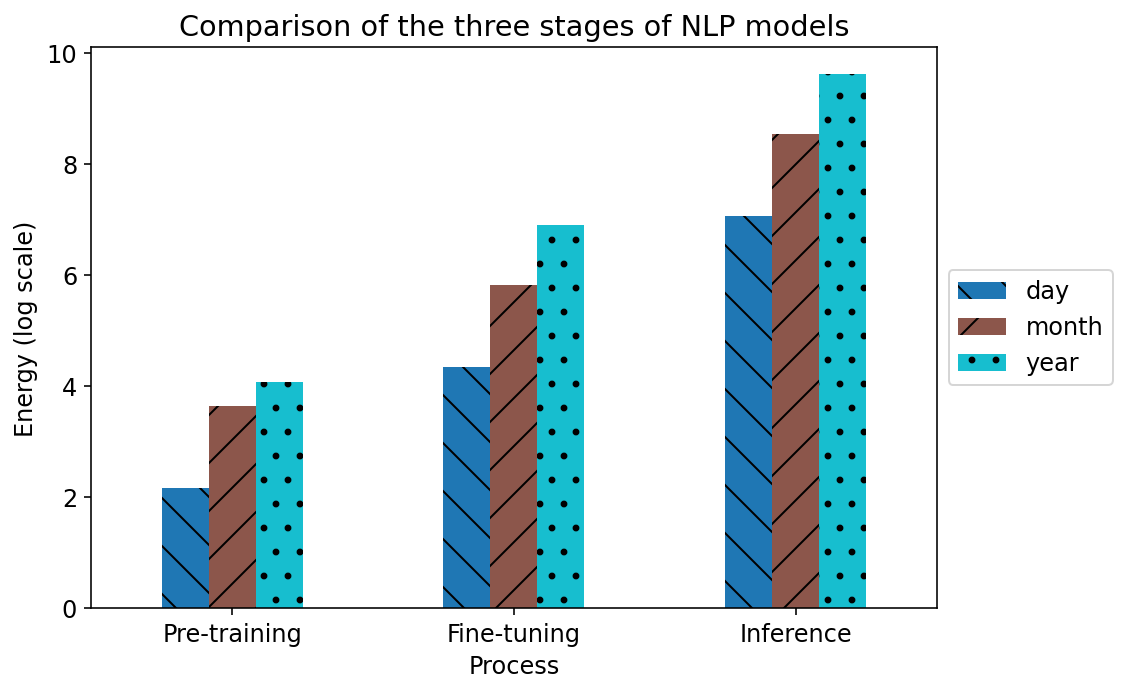

In [208]:
df_plot = mean_df
df_plot['day'] = np.log10(mean_df['daily_consumption'])
df_plot['month'] = np.log10(mean_df['monthly_consumption'])
df_plot['year'] = np.log10(mean_df['yearly_consumption'])
features = ['process','day','month', 'year']
df_plot = df_plot[features]
df_plot.set_index('process', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_plot.plot.bar(rot=0, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(df_plot) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Energy (log scale)")
ax.set_xlabel("Process")
ax.set_title("Comparison of the three stages of NLP models")
plt.tight_layout()
ax.figure.savefig("viz/overallConsumption1.png",dpi=300)

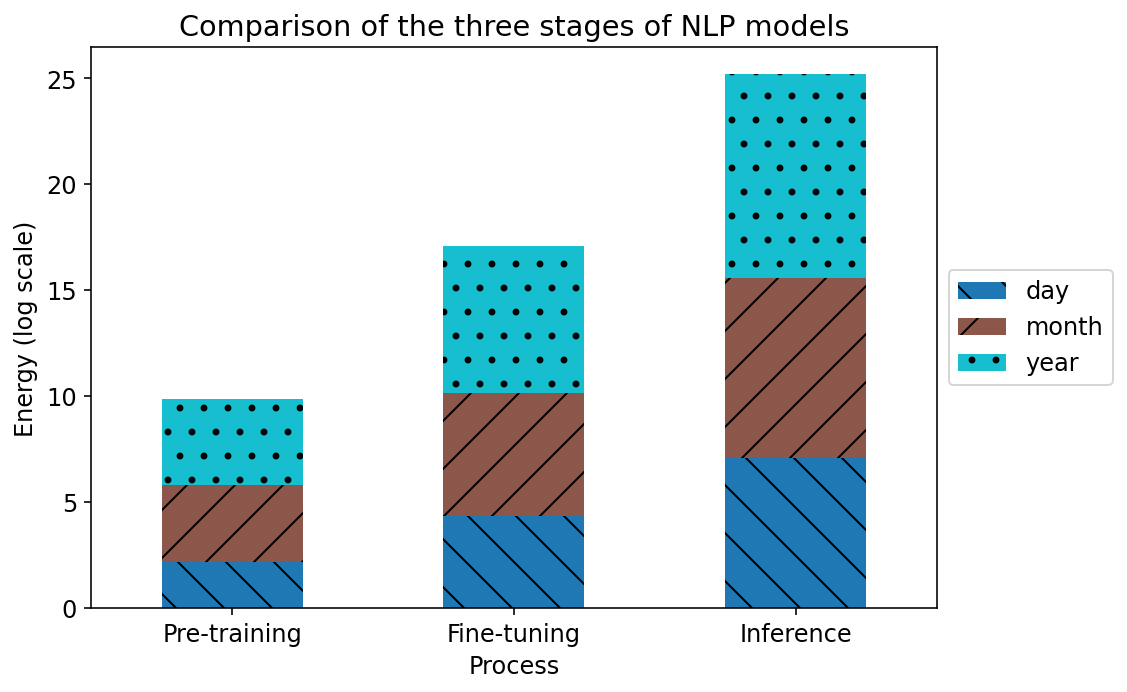

In [209]:
df_plot = mean_df
df_plot['day'] = np.log10(mean_df['daily_consumption'])
df_plot['month'] = np.log10(mean_df['monthly_consumption'])
df_plot['year'] = np.log10(mean_df['yearly_consumption'])
features = ['process','day','month', 'year']
df_plot = df_plot[features]
df_plot.set_index('process', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_plot.plot.bar(rot=0, stacked=True, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(df_plot) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Energy (log scale)")
ax.set_xlabel("Process")
ax.set_title("Comparison of the three stages of NLP models")
plt.tight_layout()
#ax.figure.savefig("viz/overallConsumption1.png",dpi=300)

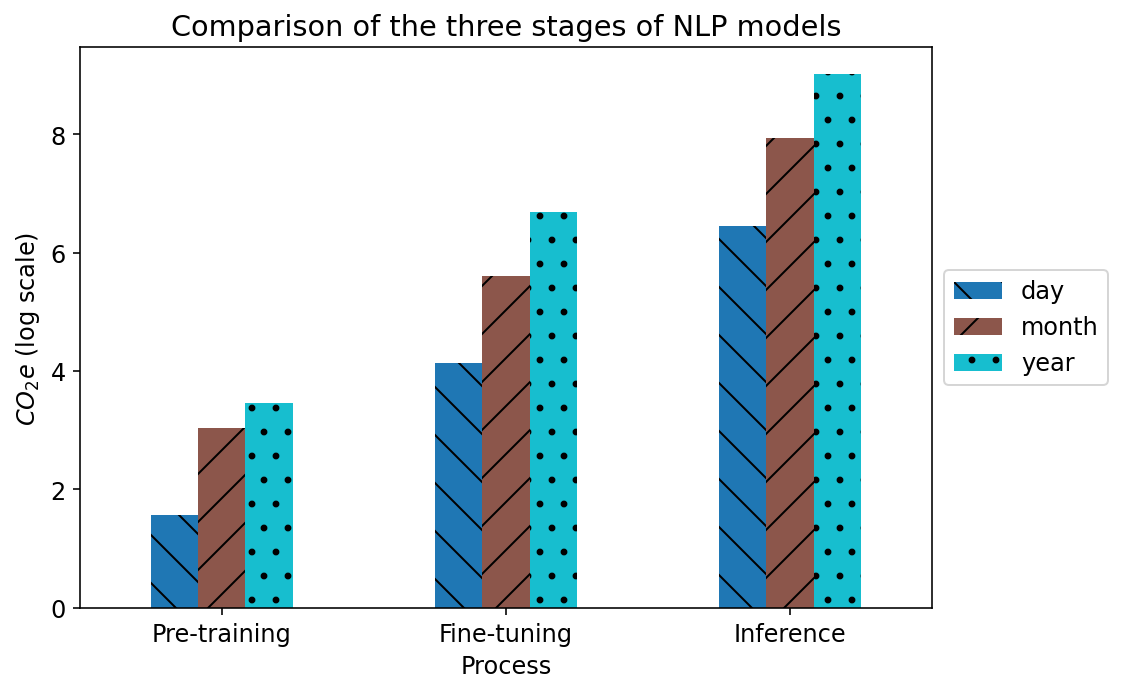

In [210]:
df_plot = mean_df

df_plot['day'] = np.log10(df_plot['daily_co2'])
df_plot['month'] = np.log10(df_plot['monthly_co2'])
df_plot['year'] = np.log10(df_plot['yearly_co2'])

features = ['process','day','month', 'year']
df_plot = df_plot[features]


df_plot.set_index('process', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_plot.plot.bar(rot=0, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(df_plot) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("$CO_2e$ (log scale)")
ax.set_xlabel("Process")
ax.set_title("Comparison of the three stages of NLP models")
plt.tight_layout()
ax.figure.savefig("viz/overallCO21.png",dpi=300)

In [211]:
(finetune_array[3] - pretrain_array[3]) /pretrain_array[3]

679.244244656268

In [212]:
(inference_array[3] - pretrain_array[3]) /pretrain_array[3]

354254.45367377275

In [213]:
transform_data = [
["Pretraining","Day",pretrain_array[1],pretrain_array[4]],
["Pretraining","Month",pretrain_array[2],pretrain_array[5]],
["Pretraining","Year",pretrain_array[3],pretrain_array[6]],
["Finetuning","Day",finetune_array[1],finetune_array[4]],
["Finetuning","Month",finetune_array[2],finetune_array[5]],
["Finetuning","Year",finetune_array[3],finetune_array[6]],
["Inference","Day",inference_array[1],inference_array[4]],
["Inference","Month",inference_array[2],inference_array[5]],
["Inference","Year",inference_array[3],inference_array[6]]]

In [214]:
plot_df = pd.DataFrame(transform_data,columns=["process", "consumption_interval", "consumption","co2"])

In [215]:
plot_df

,process,consumption_interval,consumption,co2
0,Pretraining,Day,1.442500e+02,3.649525e+01
1,Pretraining,Month,4.327500e+03,1.094858e+03
2,Pretraining,Year,1.154000e+04,2.919620e+03
3,Finetuning,Day,2.180561e+04,1.358489e+04
4,Finetuning,Month,6.541682e+05,4.075468e+05
5,Finetuning,Year,7.850019e+06,4.890562e+06
6,Inference,Day,1.120030e+07,2.833675e+06
7,Inference,Month,3.360089e+08,8.501024e+07
8,Inference,Year,4.088108e+09,1.034291e+09


log indicates fold change. Using base 10 Logarithm, every unit increase indicates 10 times increase

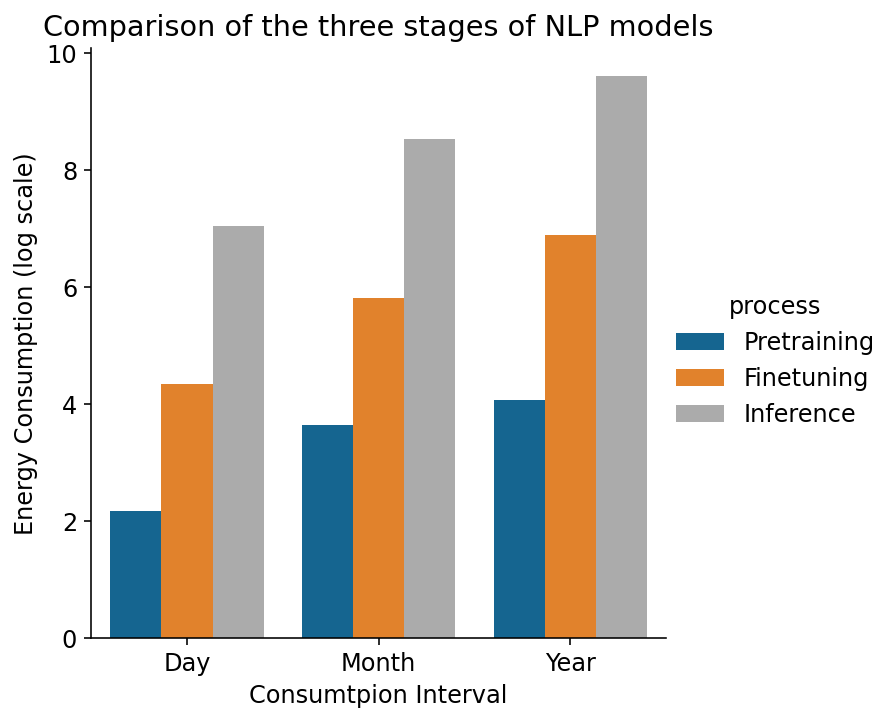

In [216]:
#plot trial
sns.axes_style("ticks")
plot_df["Consumption (log scale)"] = np.log10(plot_df['consumption'])
g = sns.catplot(x="consumption_interval", y="Consumption (log scale)", hue="process", data=plot_df,
                 kind="bar")
g.set(ylabel="Energy Consumption (log scale)", xlabel="Consumtpion Interval",
      title="Comparison of the three stages of NLP models")

plt.savefig('viz/overallConsumption.png',dpi=300)

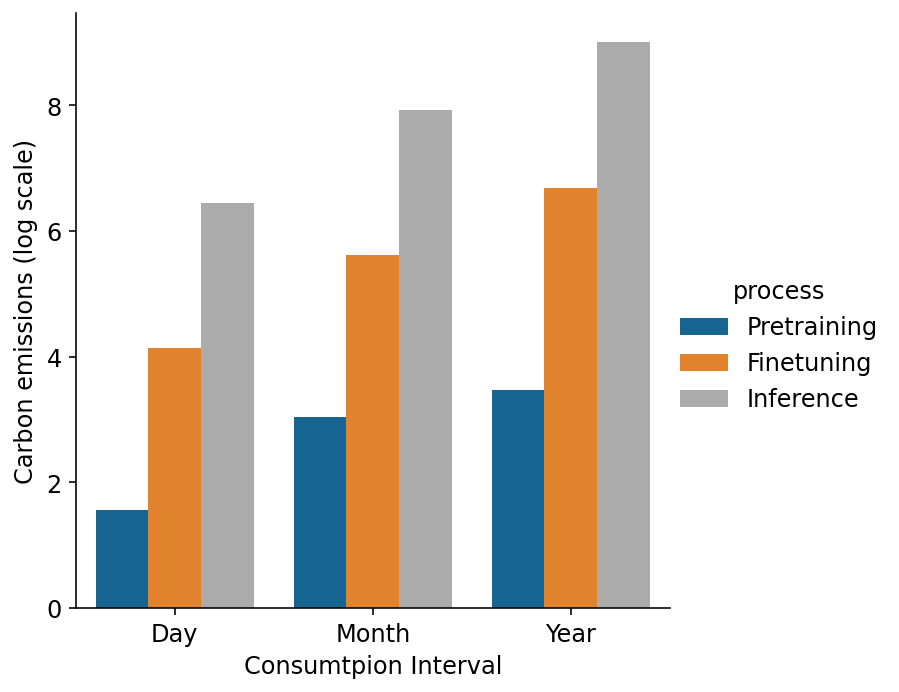

In [217]:
plot_df["CO2e (log scale)"] = np.log10(plot_df['co2'])
g = sns.catplot(x="consumption_interval", y="CO2e (log scale)", hue="process", data=plot_df,
                 kind="bar")
g.set(ylabel="Carbon emissions (log scale)", xlabel="Consumtpion Interval")
plt.savefig('viz/overallCO2.png',dpi=300)

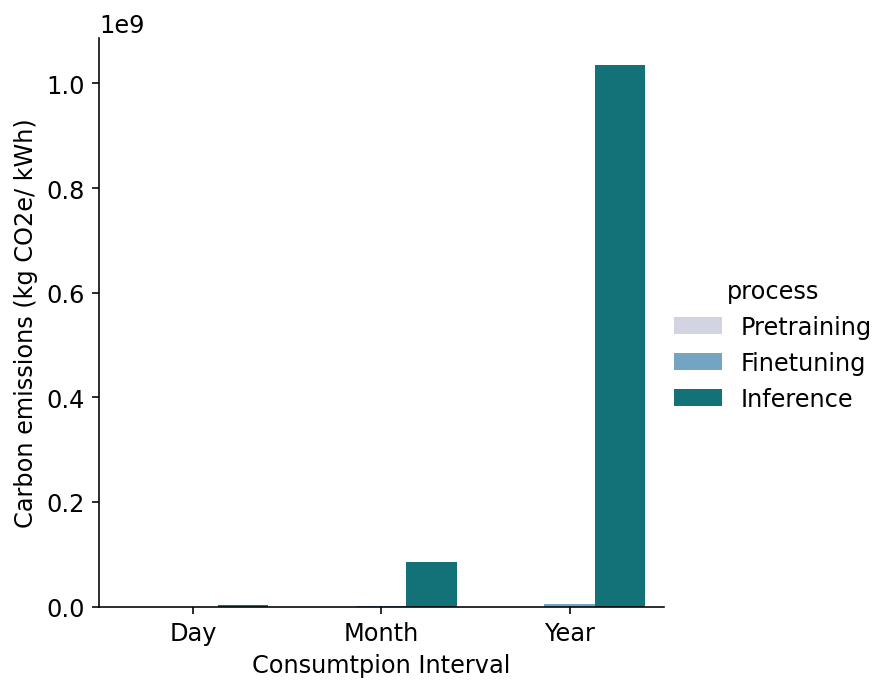

In [218]:

g = sns.catplot(x="consumption_interval", y="co2", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')
g.set(ylabel="Carbon emissions (kg CO2e/ kWh)", xlabel="Consumtpion Interval")

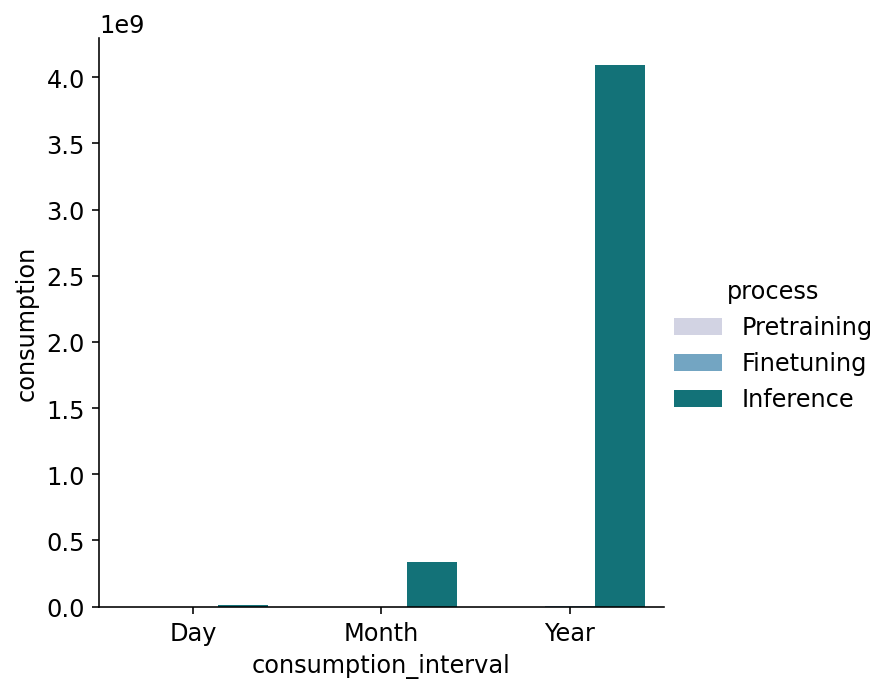

In [219]:
g = sns.catplot(x="consumption_interval", y="consumption", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')

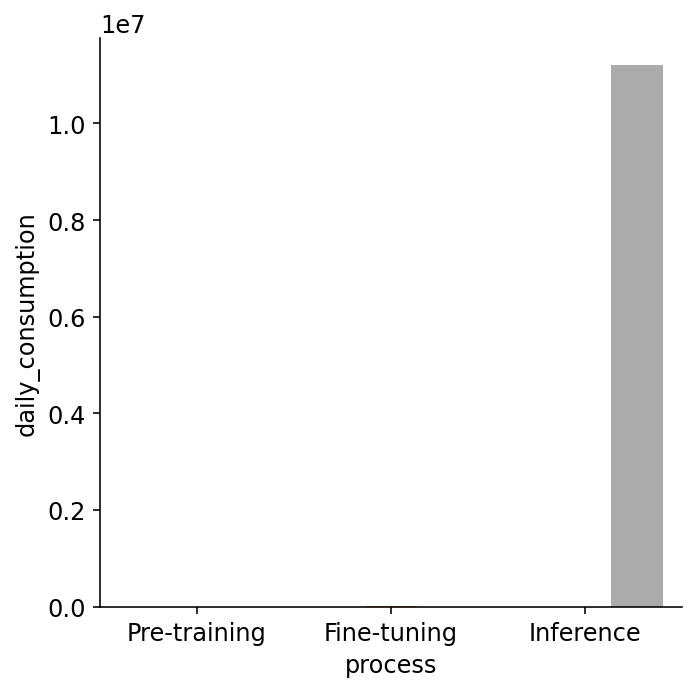

In [220]:
g = sns.catplot(x="process", y="daily_consumption", hue="process", data=mean_df,
                 kind="bar")

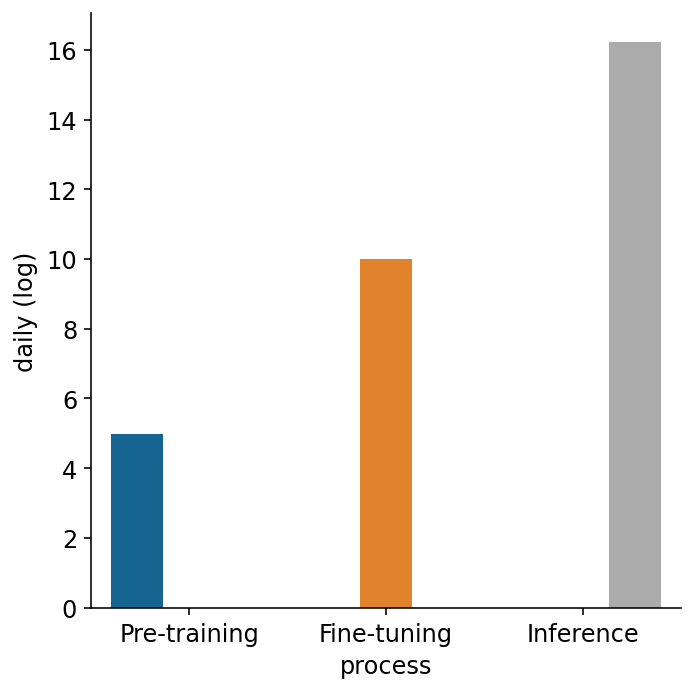

In [221]:
mean_df['daily (log)'] = np.log(mean_df['daily_consumption'])

g = sns.catplot(x="process", y="daily (log)", hue="process", data=mean_df,
                 kind="bar")

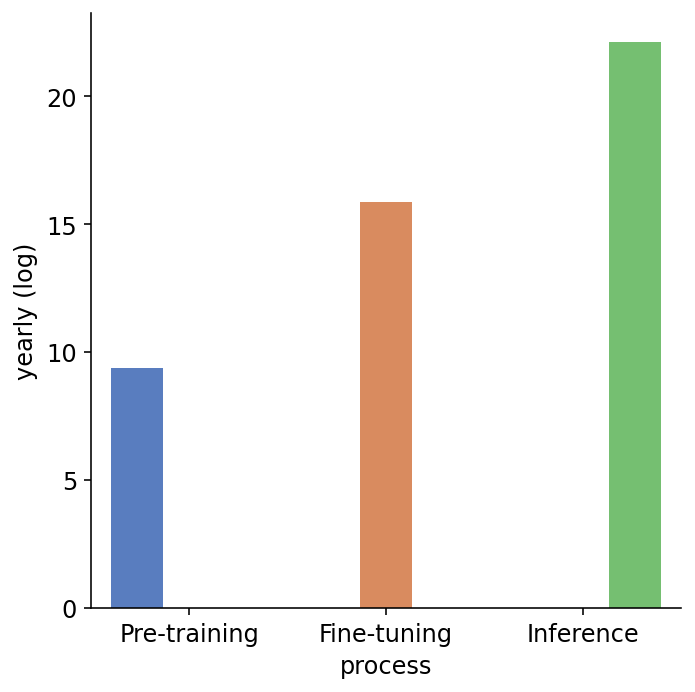

In [222]:
mean_df['yearly (log)'] = np.log(mean_df['yearly_consumption'])

g = sns.catplot(x="process", y="yearly (log)", hue="process", data=mean_df,
                 kind="bar", palette="muted")